Just one pulse

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import pearsonr
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random
import seaborn as sns
import sklearn

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map

## Setup

In [2]:
leaky_relu = LeakyReLU(alpha=0.01)

class CONFIG:
    def __init__(self):
        CONFIG.layer_1 = 12
        CONFIG.activation_1 = leaky_relu
        CONFIG.dropout = random.uniform(0.01, 0.80)
        CONFIG.layer_2 = 10
        CONFIG.activation_2 = "relu"
        CONFIG.layer_3 = 7
        CONFIG.optimizer = "adam"
        CONFIG.loss = "mae"
        CONFIG.metric = "accuracy"
        CONFIG.epoch = 6
        CONFIG.batch_size = 32


config = CONFIG()


def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer


def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=32):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds


def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 1.5])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_1_var(x, y):
    plt.scatter(X_train['BPME_13'], y_train, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('BPME_13')
    plt.ylabel('FAXS')
    plt.legend()    
    
def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r, p = pearsonr(x, y)
    ax.annotate(
        "r = {:.2f}".format(r), xy=(0.5, 0.5), xycoords="axes fraction", ha="center"
    )
    ax.set_axis_off()
    
def plot_vars_time(y):
    plt.scatter(one_pulse["Time"],y,label=str(y.name),alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel("Probe values")
    
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

Import data

In [3]:
mag_df = pd.read_csv("../JET_EFIT_magnetic/99070_MAGC.csv",index_col=0)
#mag_df = mag_df.set_index("Time")
print(mag_df.shape)

efit_df = pd.read_csv("../JET_EFIT_magnetic/99070_EFIT.csv",index_col=0)
#efit_df = efit_df.set_index("Time")
print(efit_df.shape)

# merged should be 927 x 41

merged_df = mag_df.merge(efit_df, how="outer",on="Time")
merged_df = merged_df.dropna(axis=0)
print(merged_df.head(2))
print(merged_df.shape)

(1061, 39)
(927, 3)
      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
35  0.000041  0.000129 -0.016841  0.006527 -0.017889 -0.061118 -0.011309   
36  0.000126 -0.000290 -0.000840  0.015001 -0.026383 -0.067135  0.000454   

     BPME_15   BPME_16  BPME_17  ...   FLME_38    FLME_7    FLME_8    FLME_9  \
35 -0.029960  0.005368 -0.05921  ...  0.898496 -0.023733  0.074144 -0.064945   
36 -0.057218  0.000487 -0.00163  ...  0.543274  0.005366  0.026649  0.019502   

        BVAC       FLX       IPLA   Time      FAXS      FBND  
35 -2.270235  0.001051 -242172.48  40.15 -1.116715 -1.025687  
36 -2.272149  0.001406 -236745.39  40.18 -1.123073 -1.011969  

[2 rows x 41 columns]
(927, 41)


In [4]:

#pulse_data = pd.read_csv("../JET_EFIT_magnetic/interpolated_99070.csv")
#pulse_data = pulse_data.dropna(axis=0)

pulse_data = merged_df

y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)
#X = pulse_data.drop(["FAXS", "FBND"], axis=1)


Some exploratory plots

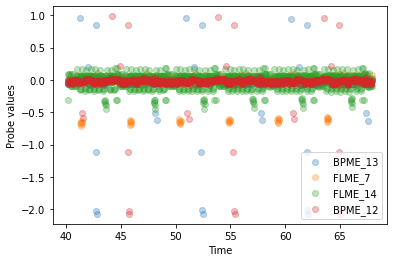

In [5]:
# plot FAXS, and some probes against time
#plot_vars_time(pulse_data["FAXS"])

# 190 to only look at one time slice
one_pulse = pulse_data

plot_vars_time(one_pulse["BPME_13"])
plot_vars_time(one_pulse["FLME_7"])
plot_vars_time(one_pulse["FLME_14"])
plot_vars_time(one_pulse["BPME_12"])
plt.legend(loc="lower right")


Check statistics

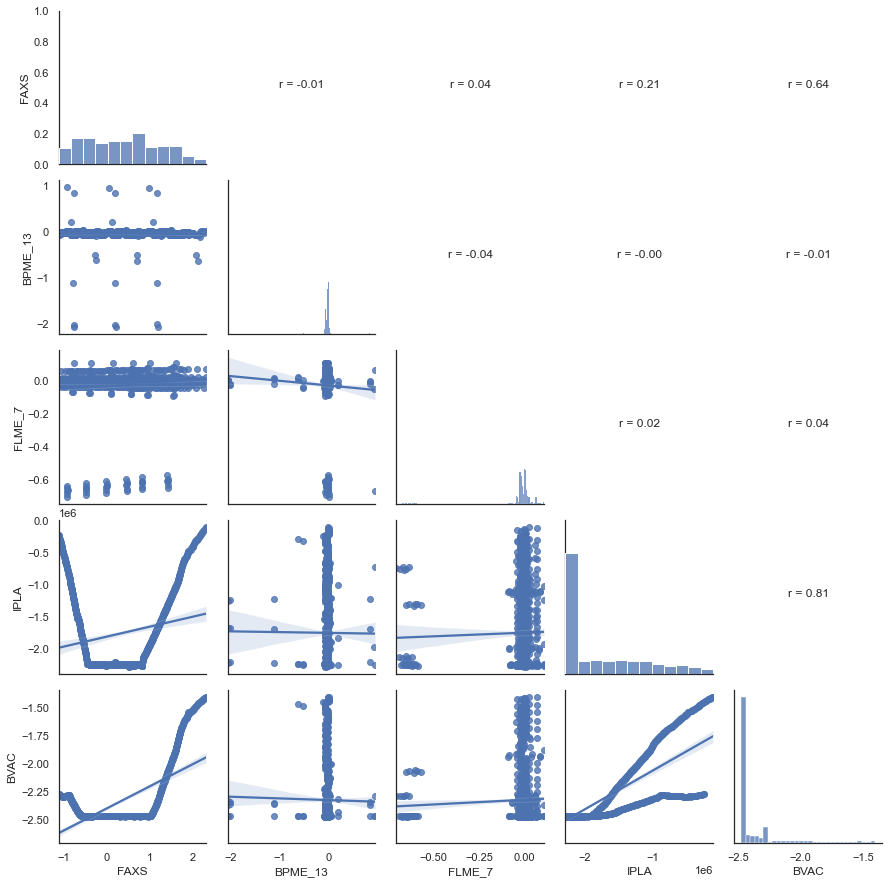

In [57]:
sns.set(style="white")

pair_plot = sns.PairGrid(pulse_data[['FAXS', 'BPME_13','FLME_7','IPLA', 'BVAC']])
pair_plot.map_diag(sns.histplot)
pair_plot.map_lower(sns.regplot)
pair_plot.map_upper(reg_coef)
plt.show()

# shall we exlcude all values close to zero? define some small range around 0 and try to ignore it?

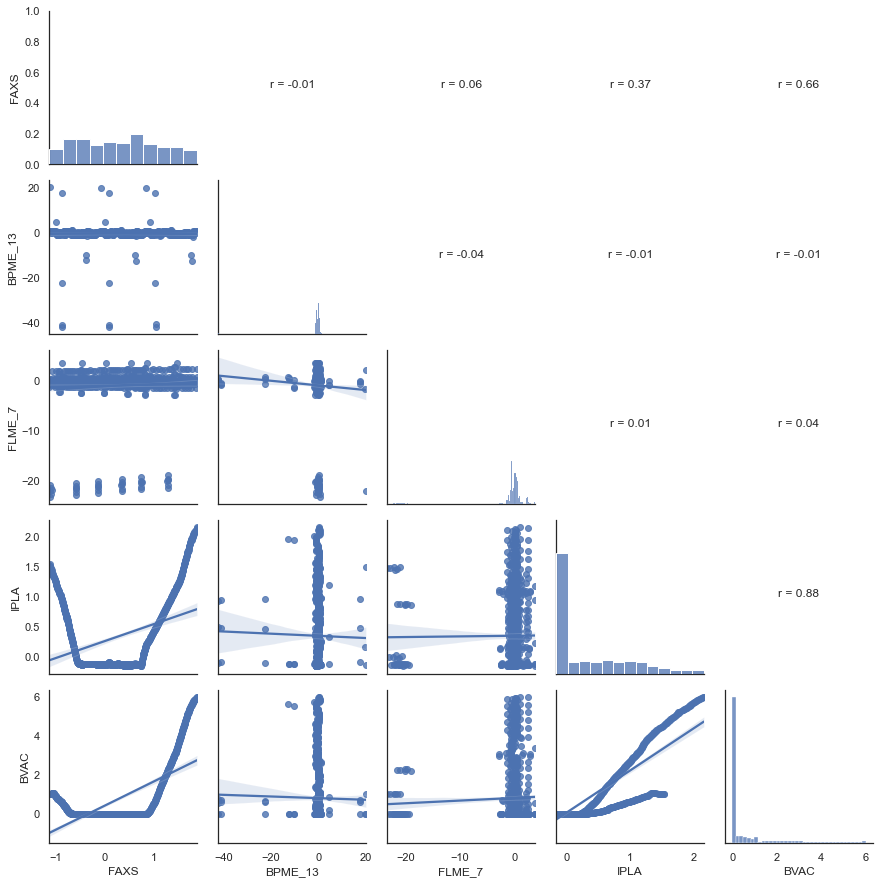

In [60]:
# try and fix distribution with scaling 
x_np = X.values #returns a numpy array
min_max_scaler = sklearn.preprocessing.RobustScaler()
x_scaled = min_max_scaler.fit_transform(x_np)
processed_df = pd.DataFrame(x_scaled, columns=X.columns)

#print(processed_df.shape)
#print(processed_df.head())
#print(y.shape)
#print(y.head())

result = pd.concat([processed_df,y],axis=1,join='inner')

#print(result.shape)
#print(result.head())

# found a mismatch in X and y indexing here? wonder if it explains the poor correlation

pair_plot2 = sns.PairGrid(result[['FAXS', 'BPME_13','FLME_7','IPLA', 'BVAC']])
pair_plot2.map_diag(sns.histplot)
pair_plot2.map_lower(sns.regplot)
pair_plot2.map_upper(reg_coef)
plt.show()

In [61]:
print(pulse_data.describe().transpose()[['mean', 'std']])


                 mean            std
BPME_0  -3.054423e-05       0.002033
BPME_1  -2.466715e-04       0.007204
BPME_10 -2.929689e-02       0.197669
BPME_11 -2.814463e-02       0.185045
BPME_12 -3.330437e-02       0.196459
BPME_13 -3.754488e-02       0.196205
BPME_14 -3.507134e-02       0.169591
BPME_15 -4.189237e-02       0.201181
BPME_16 -4.477263e-02       0.199780
BPME_17 -5.155866e-02       0.197647
BPME_18 -5.176051e-02       0.202748
BPME_2  -5.600078e-04       0.017558
BPME_3  -7.871143e-04       0.024941
BPME_4   1.526405e-03       0.085316
BPME_5   2.240609e-02       0.413235
BPME_6   1.729898e-02       0.315257
BPME_7   1.030444e-02       0.174807
BPME_8   3.632043e-03       0.142789
BPME_9  -1.748959e-02       0.198865
FLME_10 -2.630985e-02       0.120726
FLME_11 -2.263994e-02       0.122221
FLME_12 -2.158765e-02       0.120495
FLME_13 -2.015688e-02       0.117466
FLME_14 -1.846892e-02       0.114372
FLME_15 -1.591979e-02       0.114186
FLME_16 -1.372824e-02       0.114725
F

## Preprocessing

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

# doing val split inside fit for time being
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)


print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

print(type(X_train))
print(type(X))

print(X_train.describe().transpose()[['mean', 'std']])


592 train examples
149 validation examples
186 test examples
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                 mean            std
BPME_0   2.376747e-06       0.002380
BPME_1  -4.757414e-04       0.008324
BPME_10 -3.226659e-02       0.208262
BPME_11 -2.811057e-02       0.171858
BPME_12 -3.276644e-02       0.184862
BPME_13 -3.759328e-02       0.198369
BPME_14 -3.656269e-02       0.167038
BPME_15 -4.141783e-02       0.200371
BPME_16 -4.473652e-02       0.191417
BPME_17 -4.984320e-02       0.176844
BPME_18 -5.663217e-02       0.206410
BPME_2  -1.340041e-03       0.020209
BPME_3  -1.045178e-03       0.023220
BPME_4   2.114877e-03       0.106253
BPME_5   1.141874e-02       0.301311
BPME_6  -6.008390e-04       0.043931
BPME_7   1.256201e-02       0.204402
BPME_8   2.511241e-03       0.157233
BPME_9  -2.091899e-02       0.194648
FLME_10 -2.402172e-02       0.113141
FLME_11 -2.629366e-02       0.127152
FLME_12 -2.194931e-02       0.120016
FLME_13 -2.1

Preprocessing- normalisation

In [63]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())


first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


[ 2.3767650e-06 -4.7574143e-04 -3.2266594e-02 -2.8110569e-02
 -3.2766439e-02 -3.7593283e-02 -3.6562696e-02 -4.1417826e-02
 -4.4736523e-02 -4.9843192e-02 -5.6632172e-02 -1.3400409e-03
 -1.0451783e-03  2.1148766e-03  1.1418740e-02 -6.0083863e-04
  1.2562006e-02  2.5112419e-03 -2.0918988e-02 -2.4021726e-02
 -2.6293665e-02 -2.1949312e-02 -2.1788437e-02 -1.3369092e-02
 -1.9232241e-02 -1.1121899e-02 -1.0476898e-02 -8.6549986e-03
 -8.0897454e-03 -6.0594669e-03  2.5254289e-02  2.0997068e-02
 -2.6153300e-02 -2.5028795e-02 -2.3406498e-02 -2.3329859e+00
  6.0952120e-02 -1.7627329e+06]
First example: [[      -0.          0.         -0.02       -1.12       -0.05       -0.02
        -0.01       -0.07       -0.1        -0.          0.          0.
         0.         -0.         -0.          0.03       -0.         -0.02
        -0.         -0.08        0.06        0.06       -0.15        0.02
         0.01       -0.05        0.11       -0.08        0.1         0.04
         0.16        0.67        0.0

### One variable linear model
Linear regression test (one variable: BPME_13 )

In [64]:
BPME_13  = np.array(X_train['BPME_13'])

BPME_13_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
BPME_13_normalizer.adapt(BPME_13)


one_var_model = tf.keras.Sequential([
    BPME_13_normalizer,
    layers.Dense(units=1)
])

one_var_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Test one var model dims

In [65]:
print('one var predictions',one_var_model.predict(BPME_13[:10]))
""" just checking has correct dim 10x1, output expected to be bad"""
#print('actual',y_train[:10])

one_var_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


one var predictions [[-0.05652301]
 [-0.03161018]
 [-0.04798104]
 [ 0.0874248 ]
 [ 0.08202505]
 [-0.04017061]
 [-0.05476734]
 [-0.04877898]
 [-0.09888133]
 [-0.05524382]]


Train one var model, linear regression

In [66]:
history_1v = one_var_model.fit(
    X_train['BPME_13'], y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val['BPME_13'], y_val))


Test results of one var model

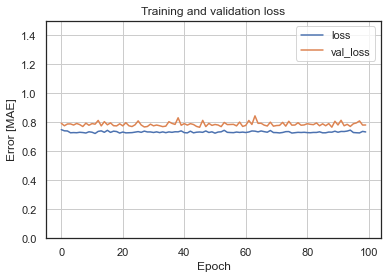

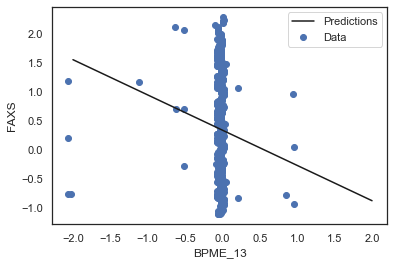

In [67]:
hist = pd.DataFrame(history_1v.history)
hist['epoch'] = history_1v.epoch
hist.tail()
plot_loss(history_1v)

onevar_x = tf.linspace(-2, 2, 20)
onevar_y = one_var_model.predict(onevar_x)

plot_1_var(onevar_x,onevar_y)


Results=very bad! are these things even correlated...


Though shows promise- should we exclude all the zero data?


Or persuade the network to weight the input less when value is near zero

### All inputs linear model

In [68]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [69]:
history = linear_model.fit(
    X_train, y_train, 
    epochs=100,
    # suppress logging
    verbose=0,
    validation_data=(X_val, y_val))


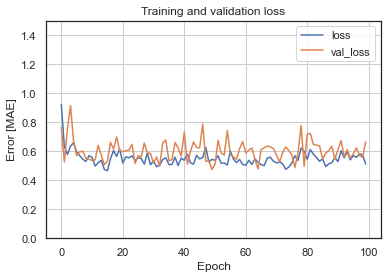

In [70]:
plot_loss(history)




Performance got worse(!)

Note: now we are including plasma current and pressure- is actually training properly/ predicting well

## Shallow NN one input

In [71]:
dnn_oneinput_model = build_and_compile_model(BPME_13_normalizer)
dnn_oneinput_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [72]:
%%time
history = dnn_oneinput_model.fit(
    X_train['BPME_13'], y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val['BPME_13'], y_val))


Wall time: 8.59 s


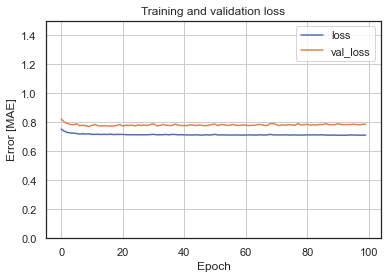

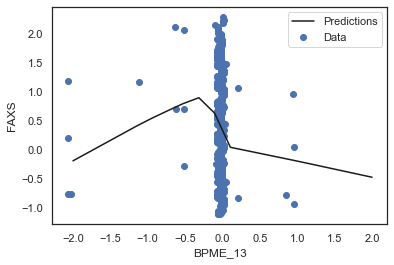

In [73]:
plot_loss(history)

#onevar_x = tf.linspace(-2, 2, 20)
# already declared above
onevar_dnn_y = dnn_oneinput_model.predict(onevar_x)

plot_1_var(onevar_x,onevar_dnn_y)


If anything performs worse than the one var linear model(!!)

Just shows we can't predict FBND/FAXS with probes alone

Shallow NN all inputs

In [74]:
"""shallow_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(40, input_dim=35),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)
"""

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2496      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 6,798
Trainable params: 6,721
Non-trainable params: 77
_________________________________________________________________


In [75]:
history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val, y_val))


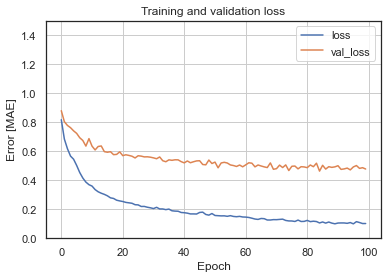

In [76]:
plot_loss(history)


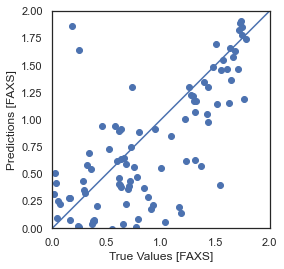

In [78]:
y_pred = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Looks like we are overfitting, try shallower model with a dropout?

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 2,478
Trainable params: 2,401
Non-trainable params: 77
_________________________________________________________________
None


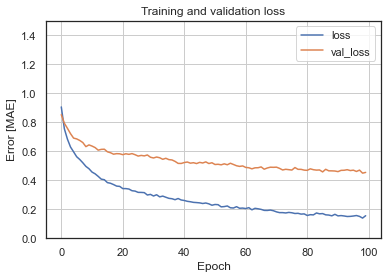

In [79]:

model = keras.Sequential(
    [   normalizer,
        layers.Dense(40, activation="relu"),
        layers.Dropout(0.01),
        layers.Dense(20, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    


print(model.summary())
history = model.fit(
    X_train, y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val, y_val))

plot_loss(history)


Getting MAE down to 0.5

### Predicting FAXS - FBND

In [6]:
pulse_data = merged_df

print(pulse_data["FAXS"])
print(pulse_data["FBND"])


X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)
#X = pulse_data.drop(["FAXS", "FBND"], axis=1)

35    -1.116715
36    -1.123073
37    -1.118021
38    -1.114052
39    -1.109803
         ...   
957    2.248127
958    2.261195
959    2.281117
960    2.299268
961    2.308747
Name: FAXS, Length: 927, dtype: float64
35    -1.025687
36    -1.011969
37    -0.996984
38    -0.983786
39    -0.969853
         ...   
957    2.336115
958    2.334902
959    2.338730
960    2.343744
961    2.344984
Name: FBND, Length: 927, dtype: float64


In [13]:
y =  pulse_data["FBND"]- pulse_data["FAXS"]
print(y.shape)
print(y.head)

(927,)
<bound method NDFrame.head of 35     0.091028
36     0.111104
37     0.121037
38     0.130266
39     0.139950
         ...   
957    0.087988
958    0.073707
959    0.057613
960    0.044476
961    0.036237
Length: 927, dtype: float64>


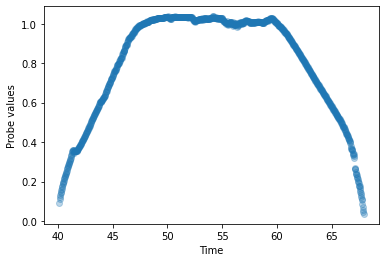

In [14]:
plot_vars_time(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

# doing val split inside fit for time being
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)


print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

print(type(X_train))
print(type(X))

print(X_train.describe().transpose()[['mean', 'std']])

592 train examples
149 validation examples
186 test examples
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                 mean            std
BPME_0   2.376747e-06       0.002380
BPME_1  -4.757414e-04       0.008324
BPME_10 -3.226659e-02       0.208262
BPME_11 -2.811057e-02       0.171858
BPME_12 -3.276644e-02       0.184862
BPME_13 -3.759328e-02       0.198369
BPME_14 -3.656269e-02       0.167038
BPME_15 -4.141783e-02       0.200371
BPME_16 -4.473652e-02       0.191417
BPME_17 -4.984320e-02       0.176844
BPME_18 -5.663217e-02       0.206410
BPME_2  -1.340041e-03       0.020209
BPME_3  -1.045178e-03       0.023220
BPME_4   2.114877e-03       0.106253
BPME_5   1.141874e-02       0.301311
BPME_6  -6.008390e-04       0.043931
BPME_7   1.256201e-02       0.204402
BPME_8   2.511241e-03       0.157233
BPME_9  -2.091899e-02       0.194648
FLME_10 -2.402172e-02       0.113141
FLME_11 -2.629366e-02       0.127152
FLME_12 -2.194931e-02       0.120016
FLME_13 -2.1

In [16]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())


first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[ 2.3767650e-06 -4.7574143e-04 -3.2266594e-02 -2.8110569e-02
 -3.2766439e-02 -3.7593283e-02 -3.6562696e-02 -4.1417826e-02
 -4.4736523e-02 -4.9843192e-02 -5.6632172e-02 -1.3400409e-03
 -1.0451783e-03  2.1148766e-03  1.1418740e-02 -6.0083863e-04
  1.2562006e-02  2.5112419e-03 -2.0918988e-02 -2.4021726e-02
 -2.6293665e-02 -2.1949312e-02 -2.1788437e-02 -1.3369092e-02
 -1.9232241e-02 -1.1121899e-02 -1.0476898e-02 -8.6549986e-03
 -8.0897454e-03 -6.0594669e-03  2.5254289e-02  2.0997068e-02
 -2.6153300e-02 -2.5028795e-02 -2.3406498e-02 -2.3329859e+00
  6.0952120e-02 -1.7627329e+06]
First example: [[      -0.          0.         -0.02       -1.12       -0.05       -0.02
        -0.01       -0.07       -0.1        -0.          0.          0.
         0.         -0.         -0.          0.03       -0.         -0.02
        -0.         -0.08        0.06        0.06       -0.15        0.02
         0.01       -0.05        0.11       -0.08        0.1         0.04
         0.16        0.67        0.0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 38)                77        
_________________________________________________________________
dense (Dense)                (None, 40)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 2,478
Trainable params: 2,401
Non-trainable params: 77
_________________________________________________________________
None


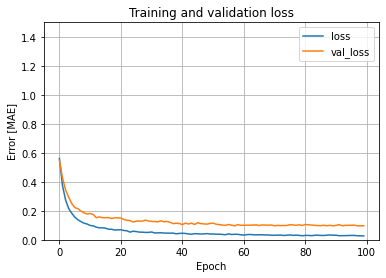

In [17]:
model = keras.Sequential(
    [   normalizer,
        layers.Dense(40, activation="relu"),
        layers.Dropout(0.01),
        layers.Dense(20, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    


print(model.summary())
history = model.fit(
    X_train, y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val, y_val))

plot_loss(history)

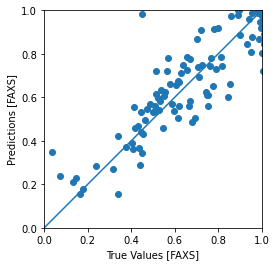

In [19]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
